In [69]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [70]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
df = pd.read_csv('../doge_v1.csv', parse_dates=['Date'], date_parser=dateparse)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,subscribers,total_issues,closed_issues,pull_requests_merged,pull_request_contributors,commit_count_4_weeks,dogecoin_unscaled,dogecoin_monthly,scale,dogecoin
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,225.0,395.000000,336.0,732.0,67.0,0.0,57,1.0,0.01,0.57
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,225.0,395.166667,336.0,732.0,67.0,0.0,24,1.0,0.01,0.24
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,225.0,395.333333,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,225.0,395.500000,336.0,732.0,67.0,0.0,23,1.0,0.01,0.23
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,225.0,395.666667,336.0,732.0,67.0,0.0,41,1.0,0.01,0.41


In [71]:
df = df.resample('D').ffill()


<AxesSubplot:xlabel='Date'>

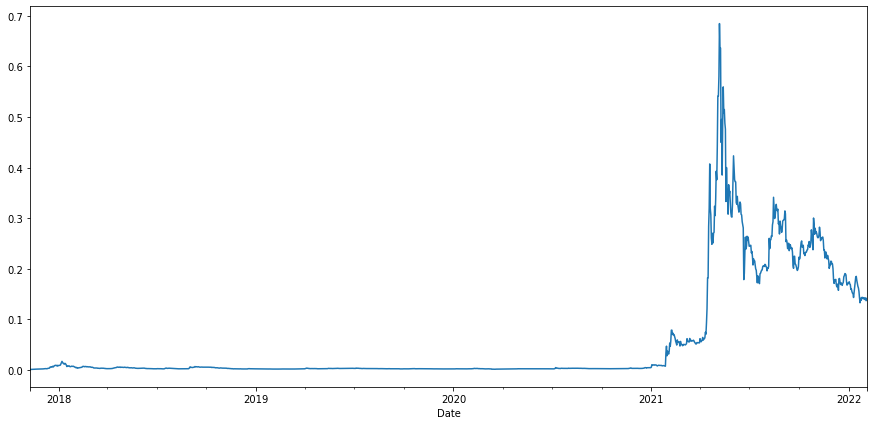

In [72]:
df.Close.plot(figsize=(15, 7))

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Freq: D
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         1549 non-null   datetime64[ns]
 1   Open                         1549 non-null   float64       
 2   High                         1549 non-null   float64       
 3   Low                          1549 non-null   float64       
 4   Close                        1549 non-null   float64       
 5   Adj Close                    1549 non-null   float64       
 6   Volume                       1549 non-null   int64         
 7   twitter_followers            1549 non-null   float64       
 8   reddit_average_posts_48h     1549 non-null   float64       
 9   reddit_average_comments_48h  1549 non-null   float64       
 10  reddit_subscribers           1549 non-null   float64       
 11  reddit_accounts_a

In [74]:
df.reset_index(drop=True, inplace=True)
lag_features = ["High", "Low", "Volume", "Open", "twitter_followers", "reddit_average_posts_48h",
                "reddit_average_comments_48h", "reddit_subscribers", "reddit_accounts_active_48h", "forks", "stars",
                "subscribers", "total_issues", "closed_issues", "pull_requests_merged", "pull_request_contributors",
                "commit_count_4_weeks", "dogecoin_monthly", "dogecoin"]
window1 = 7
window2 = 14
window3 = 30
window4 = 3

df_rolled_7d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_14d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)
df_rolled_3d = df[lag_features].rolling(window=window4, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_14d = df_rolled_14d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

df_std_14d = df_rolled_14d.mean().shift(1).reset_index().astype(np.float32)
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_14d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    df[f"{feature}_mean_lag{window4}"] = df_mean_3d[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_14d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    df[f"{feature}_std_lag{window4}"] = df_std_3d[feature]

df.fillna(df.mean(), inplace=True)
df.set_index(["Date"], drop=False, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,dogecoin_monthly_std_lag30,dogecoin_monthly_std_lag3,dogecoin_mean_lag7,dogecoin_mean_lag14,dogecoin_mean_lag30,dogecoin_mean_lag3,dogecoin_std_lag7,dogecoin_std_lag14,dogecoin_std_lag30,dogecoin_std_lag3
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-09,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,165257.000000,0.633,9.490,...,2.247506,0.348575,1.893976,1.890241,1.880544,1.896691,0.782132,1.890241,1.439431,0.517636
2017-11-10,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,165308.000000,0.833,11.958,...,2.247506,0.348575,0.570000,0.570000,0.570000,0.570000,0.782132,0.570000,1.439431,0.517636
2017-11-11,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,165363.000000,0.980,13.224,...,0.000000,0.000000,0.405000,0.405000,0.405000,0.405000,0.233345,0.405000,0.233345,0.233345
2017-11-12,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,165402.000000,1.102,14.469,...,0.000000,0.000000,0.346667,0.346667,0.346667,0.346667,0.193477,0.346667,0.193477,0.193477
2017-11-13,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,165452.666667,1.277,15.383,...,0.000000,0.000000,0.317500,0.317500,0.317500,0.233333,0.168399,0.317500,0.168399,0.005774


In [75]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1549 entries, 2017-11-09 to 2022-02-04
Columns: 176 entries, Date to dogecoin_std_lag3
dtypes: datetime64[ns](1), float32(152), float64(21), int64(2)
memory usage: 1.2 MB


In [76]:
df_exogenous_cols = list(df.columns)[24:]
print(df_exogenous_cols)


['High_mean_lag7', 'High_mean_lag14', 'High_mean_lag30', 'High_mean_lag3', 'High_std_lag7', 'High_std_lag14', 'High_std_lag30', 'High_std_lag3', 'Low_mean_lag7', 'Low_mean_lag14', 'Low_mean_lag30', 'Low_mean_lag3', 'Low_std_lag7', 'Low_std_lag14', 'Low_std_lag30', 'Low_std_lag3', 'Volume_mean_lag7', 'Volume_mean_lag14', 'Volume_mean_lag30', 'Volume_mean_lag3', 'Volume_std_lag7', 'Volume_std_lag14', 'Volume_std_lag30', 'Volume_std_lag3', 'Open_mean_lag7', 'Open_mean_lag14', 'Open_mean_lag30', 'Open_mean_lag3', 'Open_std_lag7', 'Open_std_lag14', 'Open_std_lag30', 'Open_std_lag3', 'twitter_followers_mean_lag7', 'twitter_followers_mean_lag14', 'twitter_followers_mean_lag30', 'twitter_followers_mean_lag3', 'twitter_followers_std_lag7', 'twitter_followers_std_lag14', 'twitter_followers_std_lag30', 'twitter_followers_std_lag3', 'reddit_average_posts_48h_mean_lag7', 'reddit_average_posts_48h_mean_lag14', 'reddit_average_posts_48h_mean_lag30', 'reddit_average_posts_48h_mean_lag3', 'reddit_avera

In [77]:
testNum = round(df.shape[0] * 0.1)
train = df.iloc[:-testNum]
test = df.iloc[-testNum:]


In [78]:
from pmdarima import auto_arima

model = auto_arima(train.Close, exogenous=train[df_exogenous_cols], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[df_exogenous_cols])

forecast = model.predict(n_periods=len(test), exogenous=test[df_exogenous_cols])
test["Forecast_ARIMAX"] = forecast


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-9326.963, Time=57.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-9149.566, Time=48.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-9243.329, Time=47.72 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-9212.303, Time=55.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-458.004, Time=47.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-9330.318, Time=57.08 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-9263.280, Time=56.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-9302.946, Time=56.13 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-9328.657, Time=64.55 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-9290.113, Time=64.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-9329.539, Time=56.90 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-9326.915, Time=64.57 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-9332.182, Time=56.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-9264.485, Time=56.15 sec
 ARIMA

<AxesSubplot:xlabel='Date'>

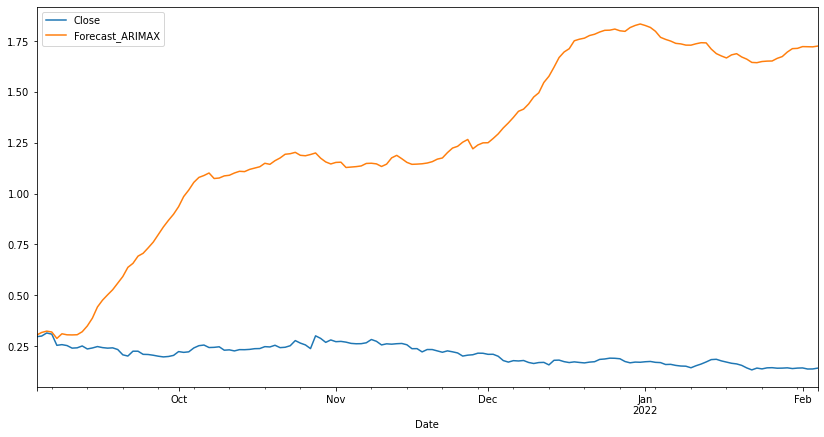

In [79]:
test[["Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))


In [80]:
forecast = model.predict(n_periods=len(df), exogenous=df[df_exogenous_cols])
df["Forecast_ARIMAX"] = forecast

<AxesSubplot:xlabel='Date'>

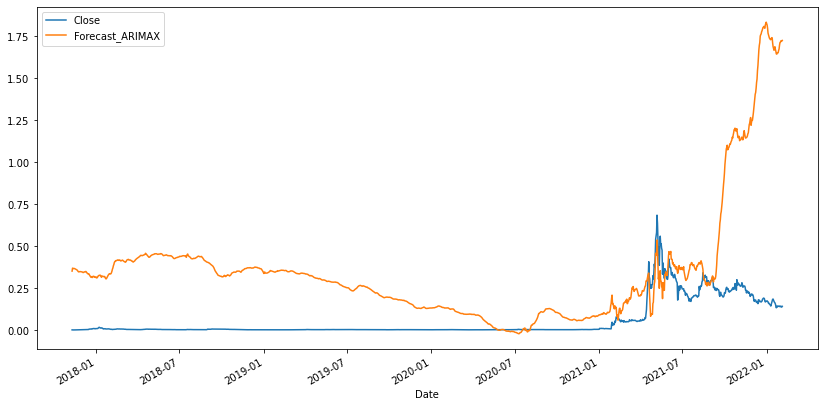

In [81]:
df[["Close", "Forecast_ARIMAX"]].plot(figsize=(14, 7))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8653.227, Time=14.16 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8585.539, Time=13.85 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8602.381, Time=11.65 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8595.757, Time=11.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=111.928, Time=9.51 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-8653.052, Time=13.86 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8666.214, Time=11.99 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-8610.262, Time=11.54 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-8658.939, Time=11.82 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-8661.277, Time=14.58 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-8662.743, Time=13.81 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-8569.886, Time=14.66 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-8668.235, Time=12.45 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-8612.308, Time=12.46 sec
 ARIMA(2

<AxesSubplot:xlabel='Date'>

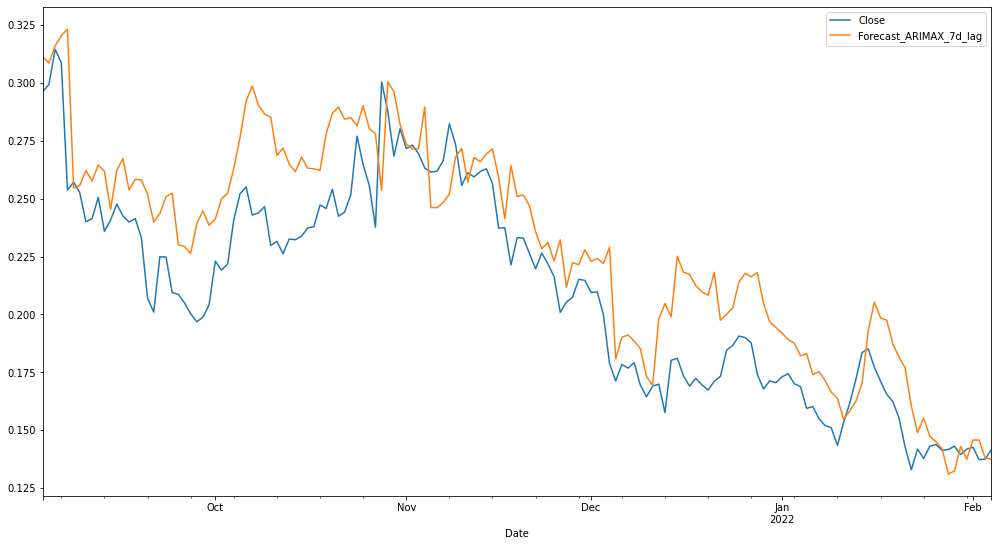

In [82]:
#Pokusavam predikciju nad lagom od 7 dana
exog_7_days = []
for feature in lag_features:
    exog_7_days.append(f"{feature}_mean_lag{window1}")
    exog_7_days.append(f"{feature}_std_lag{window1}")

model = auto_arima(train.Close, exogenous=train[exog_7_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_7_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_7_days])
test["Forecast_ARIMAX_7d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_7d_lag"]].plot(figsize=(17, 9))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8519.196, Time=14.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8425.351, Time=10.89 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8423.351, Time=11.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8422.543, Time=12.98 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=265.284, Time=11.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8508.979, Time=14.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8521.856, Time=15.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8416.055, Time=16.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8514.769, Time=16.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-8519.095, Time=16.03 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-8521.008, Time=14.73 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-8409.632, Time=15.84 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8523.592, Time=14.00 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8417.611, Time=13.34 sec
 ARIMA(

<AxesSubplot:xlabel='Date'>

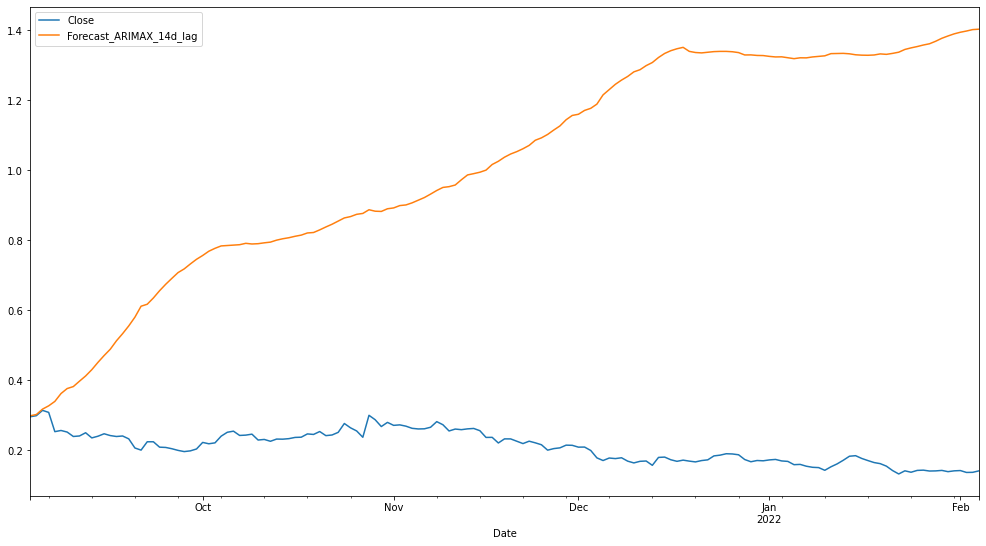

In [83]:
#Pokusavam predikciju nad lagom od 14 dana
exog_14_days = []
for feature in lag_features:
    exog_14_days.append(f"{feature}_mean_lag{window2}")
    exog_14_days.append(f"{feature}_std_lag{window2}")

model = auto_arima(train.Close, exogenous=train[exog_14_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_14_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_14_days])
test["Forecast_ARIMAX_14d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_14d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8628.866, Time=14.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8537.576, Time=12.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8546.867, Time=12.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8543.087, Time=15.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=152.979, Time=11.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8630.881, Time=16.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8628.227, Time=15.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8563.763, Time=14.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8624.687, Time=16.91 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8626.938, Time=18.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8629.481, Time=16.81 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8625.051, Time=17.40 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-8632.621, Time=14.32 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-8629.985, Time=14.00 sec
 ARIMA(

<AxesSubplot:xlabel='Date'>

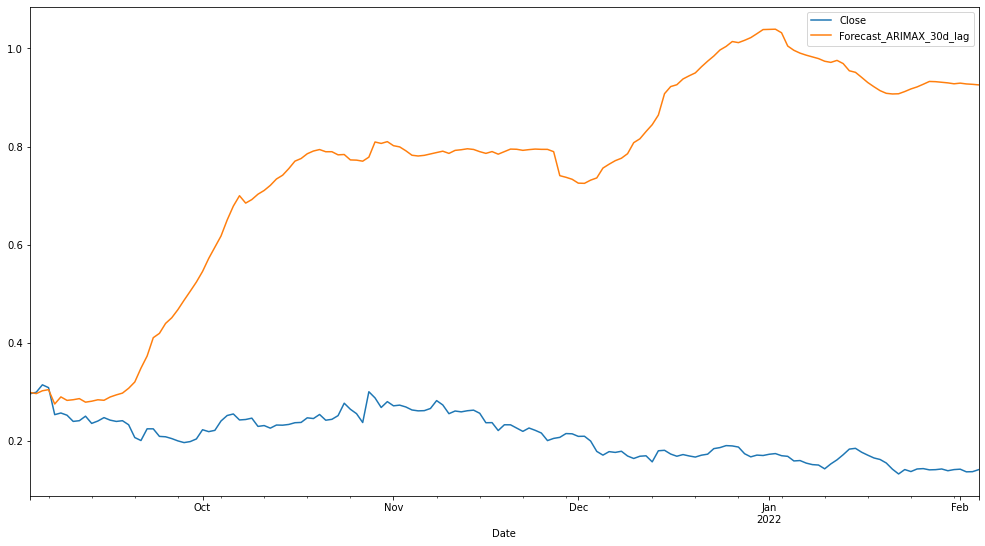

In [84]:
#Pokusavam predikciju nad lagom od 30 dana
exog_30_days = []
for feature in lag_features:
    exog_30_days.append(f"{feature}_mean_lag{window3}")
    exog_30_days.append(f"{feature}_std_lag{window3}")

model = auto_arima(train.Close, exogenous=train[exog_30_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_30_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_30_days])
test["Forecast_ARIMAX_30d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_30d_lag"]].plot(figsize=(17, 9))


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-8606.313, Time=18.23 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-8417.285, Time=11.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-8419.118, Time=11.48 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-8409.891, Time=12.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=280.183, Time=10.79 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-8600.092, Time=16.97 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-8396.858, Time=15.98 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-8596.594, Time=17.30 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-8618.715, Time=18.38 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-8621.545, Time=18.49 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-8571.764, Time=18.98 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-8564.574, Time=18.85 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-8502.808, Time=18.33 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=-8601.909, Time=25.49 sec
 ARIMA(

<AxesSubplot:xlabel='Date'>

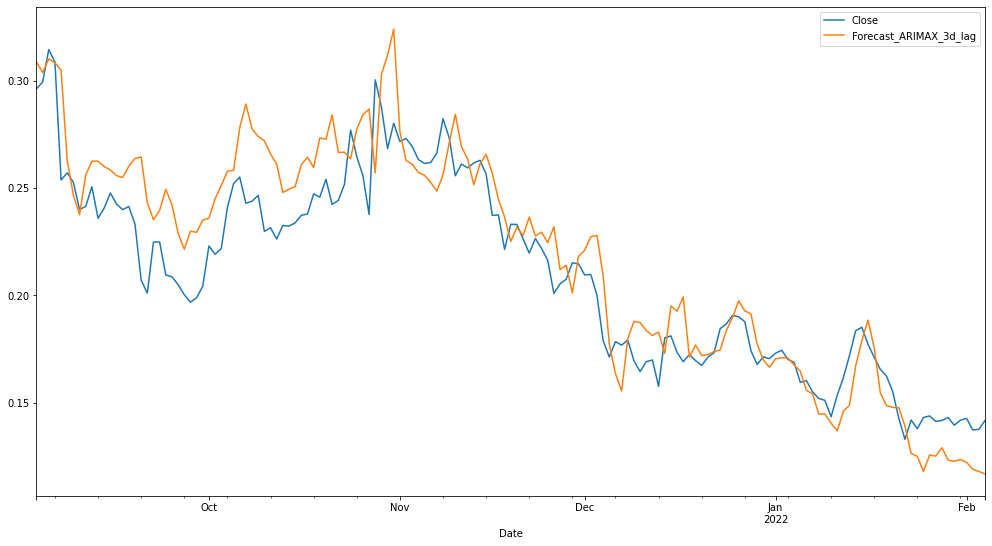

In [85]:
#Pokusavam predikciju nad lagom od 3 dana
exog_3_days = []
for feature in lag_features:
    exog_3_days.append(f"{feature}_mean_lag{window4}")
    exog_3_days.append(f"{feature}_std_lag{window4}")

model = auto_arima(train.Close, exogenous=train[exog_3_days], trace=True, error_action="ignore",
                   suppress_warnings=True)
model.fit(train.Close, exogenous=train[exog_3_days])

forecast = model.predict(n_periods=len(test), exogenous=test[exog_3_days])
test["Forecast_ARIMAX_3d_lag"] = forecast
test[["Close", "Forecast_ARIMAX_3d_lag"]].plot(figsize=(17, 9))


In [86]:
def mape(actual,pred):
    return np.mean(np.abs((actual - pred) / actual)) * 100

d3_mape = mape(test.Close, test.Forecast_ARIMAX_3d_lag)
d7_mape = mape(test.Close, test.Forecast_ARIMAX_7d_lag)
d14_mape = mape(test.Close, test.Forecast_ARIMAX_14d_lag)
d30_mape = mape(test.Close, test.Forecast_ARIMAX_30d_lag)
print(f"MAPE 3D: {d3_mape}")
print(f"MAPE 7D: {d7_mape}")
print(f"MAPE 14D: {d14_mape}")
print(f"MAPE 30D: {d30_mape}")

MAPE 3D: 7.77885754947178
MAPE 7D: 10.672888385238577
MAPE 14D: 434.5315101621284
MAPE 30D: 290.4462362282544


In [88]:
test.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,dogecoin_mean_lag3,dogecoin_std_lag7,dogecoin_std_lag14,dogecoin_std_lag30,dogecoin_std_lag3,Forecast_ARIMAX,Forecast_ARIMAX_7d_lag,Forecast_ARIMAX_14d_lag,Forecast_ARIMAX_30d_lag,Forecast_ARIMAX_3d_lag
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-31,2022-01-31,0.139469,0.142264,0.136853,0.141805,0.141805,412307174,2971374.0,9.000,487.909,...,1.366667,0.595363,1.866429,1.105606,0.397157,1.714231,0.137422,1.390090,0.927863,0.123472
2022-02-01,2022-02-01,0.141805,0.144129,0.141125,0.142631,0.142631,409432267,2977053.0,8.889,500.778,...,1.113333,0.675856,1.810714,1.117027,0.334863,1.722876,0.145745,1.394679,0.929209,0.122168
2022-02-02,2022-02-02,0.142626,0.145253,0.136918,0.137235,0.137235,483194691,2982243.0,8.167,514.167,...,1.853333,0.975461,1.972857,1.149820,1.616581,1.722057,0.145720,1.398170,0.927564,0.118898
2022-02-03,2022-02-03,0.137213,0.138747,0.135565,0.137541,0.137541,383506507,2987430.0,6.455,404.000,...,2.706667,1.142070,2.107143,1.166931,1.551945,1.721663,0.137787,1.402261,0.926779,0.117921
2022-02-04,2022-02-04,0.137687,0.142551,0.137261,0.141685,0.141685,454621984,2991859.0,10.375,822.000,...,3.493333,1.234975,2.223572,1.172086,0.220303,1.725474,0.137578,1.403406,0.925639,0.116739


In [119]:
#Predvidjam dalje 3 dana u buducnost van okvira test podataka
test_tail_7 = test.tail(7)
test_tail_7.head(7)
test_tail_7.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test_tail_7['Date'] = test_tail_7['Date'] + pd.DateOffset(days=7)

In [120]:
test_tail_7.tail(7)

,Date,Open,High,Low,Close,Adj Close,Volume,twitter_followers,reddit_average_posts_48h,reddit_average_comments_48h,...,"(2, dogecoin_mean_lag3)","(2, dogecoin_std_lag3)","(3, dogecoin_mean_lag3)","(3, dogecoin_std_lag3)","(4, dogecoin_mean_lag3)","(4, dogecoin_std_lag3)","(5, dogecoin_mean_lag3)","(5, dogecoin_std_lag3)","(6, dogecoin_mean_lag3)","(6, dogecoin_std_lag3)"
0,2022-02-05,0.141649,0.143984,0.141480,0.143056,0.143056,397610776,2958876.0,8.900,571.900,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0
1,2022-02-06,0.143057,0.143515,0.138754,0.139471,0.139471,363976741,2965408.0,8.100,496.300,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0
2,2022-02-07,0.139469,0.142264,0.136853,0.141805,0.141805,412307174,2971374.0,9.000,487.909,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0
3,2022-02-08,0.141805,0.144129,0.141125,0.142631,0.142631,409432267,2977053.0,8.889,500.778,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0
4,2022-02-09,0.142626,0.145253,0.136918,0.137235,0.137235,483194691,2982243.0,8.167,514.167,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0
5,2022-02-10,0.137213,0.138747,0.135565,0.137541,0.137541,383506507,2987430.0,6.455,404.000,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0
6,2022-02-11,0.137687,0.142551,0.137261,0.141685,0.141685,454621984,2991859.0,10.375,822.000,...,0.92,0.92,3.72,3.72,3.48,3.48,3.28,3.28,4.0,4.0


In [121]:

for feature in lag_features:
    for i in range(0,7):
        test_tail_7[i, f"{feature}_mean_lag{window4}"] = test.iloc[len(test) - 7 + i][f"{feature}"]
        test_tail_7[i, f"{feature}_std_lag{window4}"] = test.iloc[len(test) - 7 + i][f"{feature}"]

test = test.append(test_tail_7)
test.set_index(["Date"], drop=False, inplace=True)


<AxesSubplot:xlabel='Date'>

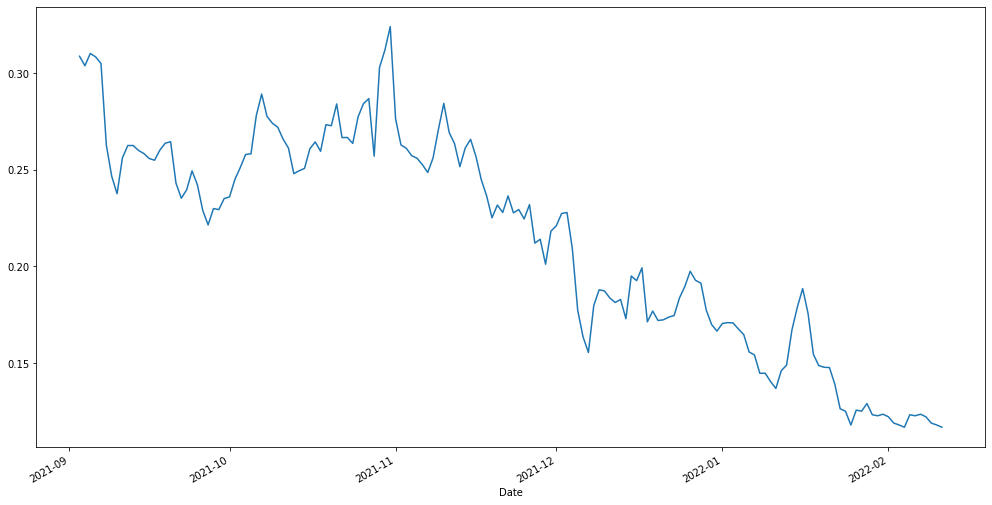

In [122]:
forecast = model.predict(n_periods=len(test), exogenous=test[exog_3_days], dynamic=True)
test["Forecast_ARIMAX_3d_lag"] = forecast
test["Forecast_ARIMAX_3d_lag"].plot(figsize=(17, 9))


In [124]:
print(test.iloc[-14:]["Forecast_ARIMAX_3d_lag"])


Date
2022-01-29    0.123196
2022-01-30    0.122676
2022-01-31    0.123472
2022-02-01    0.122168
2022-02-02    0.118898
2022-02-03    0.117921
2022-02-04    0.116739
2022-02-05    0.123196
2022-02-06    0.122676
2022-02-07    0.123472
2022-02-08    0.122168
2022-02-09    0.118898
2022-02-10    0.117921
2022-02-11    0.116739
Name: Forecast_ARIMAX_3d_lag, dtype: float64
